In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter  # TensorBoard 임포트
from sklearn.metrics import mean_absolute_error

In [12]:
# CSV 파일 로드
df = pd.read_csv('/Users/juwonkim/Desktop/4학년 1학기/캡스톤 디자인/seasons/final.csv', parse_dates=['DateTime'])

# 날짜 기준으로 train/test 분리
train_df = df[df['DateTime'] < '2020-05']
test_df = df[df['DateTime'] >= '2020-05']

# 'DateTime' 열 제거 및 필요한 열만 사용
train_df = train_df[['Chelsea_Points']]
test_df = test_df[['Chelsea_Points']]

# 정규화
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df)
test_data = scaler.transform(test_df)


In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 10  # 시퀀스 길이 설정
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)


Epoch [10/100], Loss: 0.0194, MAE: 0.1414
Epoch [20/100], Loss: 0.0136, MAE: 0.0690
Epoch [30/100], Loss: 0.0124, MAE: 0.0848
Epoch [40/100], Loss: 0.0128, MAE: 0.0435
Epoch [50/100], Loss: 0.0126, MAE: 0.0786
Epoch [60/100], Loss: 0.0122, MAE: 0.0514
Epoch [70/100], Loss: 0.0123, MAE: 0.0755
Epoch [80/100], Loss: 0.0120, MAE: 0.0694
Epoch [90/100], Loss: 0.0119, MAE: 0.0813
Epoch [100/100], Loss: 0.0119, MAE: 0.0810


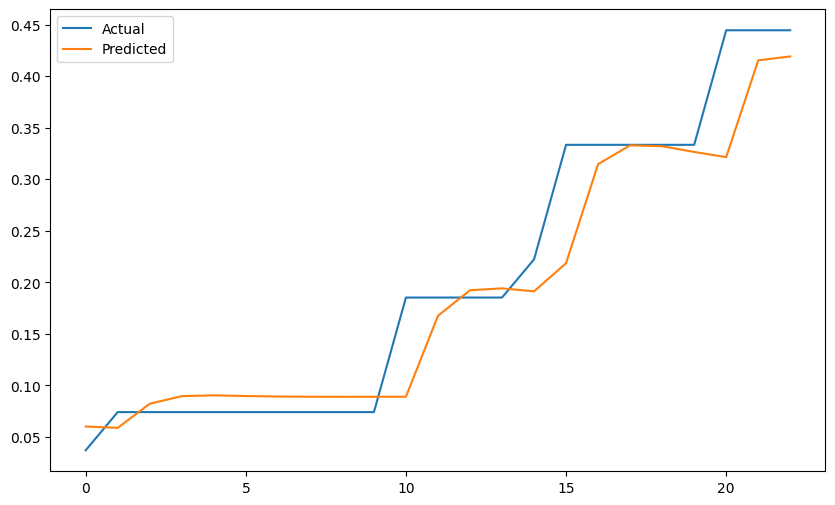

Actual: 0.03703703731298447, Predicted: 0.0600777231156826
Actual: 0.07407407462596893, Predicted: 0.05880070850253105
Actual: 0.07407407462596893, Predicted: 0.08218123018741608
Actual: 0.07407407462596893, Predicted: 0.08956597745418549
Actual: 0.07407407462596893, Predicted: 0.09032617509365082
Actual: 0.07407407462596893, Predicted: 0.08967171609401703
Actual: 0.07407407462596893, Predicted: 0.08917391300201416
Actual: 0.07407407462596893, Predicted: 0.08897586166858673
Actual: 0.07407407462596893, Predicted: 0.0889313817024231
Actual: 0.07407407462596893, Predicted: 0.08894911408424377
Actual: 0.18518517911434174, Predicted: 0.08897602558135986
Actual: 0.18518517911434174, Predicted: 0.16752366721630096
Actual: 0.18518517911434174, Predicted: 0.19227159023284912
Actual: 0.18518517911434174, Predicted: 0.19409921765327454
Actual: 0.2222222238779068, Predicted: 0.19121889770030975
Actual: 0.3333333432674408, Predicted: 0.21854349970817566
Actual: 0.3333333432674408, Predicted: 0.314

In [15]:
# 텐서보드 설정
log_dir = "runs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # MAE 계산
    mae_train = mean_absolute_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('MAE/train', mae_train, epoch)  # 텐서보드에 MAE 값 기록
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, MAE: {mae_train:.4f}')


# 평가 및 예측
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.item())
        actuals.append(targets.item())
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

# 예측 결과 출력
for i in range(len(predictions)):
    print(f"Actual: {actuals[i]}, Predicted: {predictions[i]}")

# 테스트 데이터에 대한 MAE 계산
mae_test = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE) on test data: {mae_test:.4f}")

# 텐서보드 종료
writer.close()

